In [1]:
from Iris_recognition import *
from Periocular_recognition import *
import os

In [2]:
fold_num = 2

## Image Loading

In [3]:
def create_dataset(img_folder, fold):

    test_data=[]
    test_label=[]
    fold_list=[i for i in range(fold - 1, fold + 3)]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in fold_list): # 2 4 6 8
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
    
    np.save(f'temp_data/Fusion_x_fold{fold}.npy', test_data)
    np.save(f'temp_data/Fusion_y_fold{fold}.npy', test_label)         
    return np.array(test_data), np.array(test_label)

In [ ]:
X_test, y_test = create_dataset('Iris-Dataset/CASIA-Iris-Thousand', fold_num)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
def load_dataset(fold):
    Fusion_X, Fusion_y = combine_LR(np.load(f'temp_data/Fusion_x_fold{fold}.npy'), 
                                    np.load(f'temp_data/Fusion_y_fold{fold}.npy'), 
                                    1000, 4)
    
    model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(64, 128, 3))
    with tf.device('GPU:0'):
        features_test = model.predict(Fusion_X)

    return features_test, Fusion_X, Fusion_y

In [5]:
features_test, Fusion_X, Fusion_y = load_dataset(fold_num)

125/125 [==============================] - 11s 21ms/step


In [19]:
# plt.figure(figsize=(10, 10))
# plt.imshow((Fusion_X[5]*255).astype(np.uint8))

# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)

In [6]:
iris_norm_L = np.load('temp_data/iris_norm_L_all.npy')
iris_norm_R = np.load('temp_data/iris_norm_R_all.npy')

In [7]:
def create_fold_norm(fold):
    iris_norm_L_fold = []
    iris_norm_R_fold = []
    for fol in range(1000):
        for item in range(4):
            iris_norm_L_fold.append(iris_norm_L[fol*10+item+fold])
            iris_norm_R_fold.append(iris_norm_R[fol*10+item+fold])
    return np.array(iris_norm_L_fold), np.array(iris_norm_R_fold)

In [8]:
iris_norm_L_fold, iris_norm_R_fold = create_fold_norm(fold_num-1)

## Normal Accuracy

In [6]:
def accuracy_score(ref_num, test_num, same_num=2):
    # features_test, Fusion_X, Fusion_y = load_dataset()
    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []
    for img_1_fol in tqdm(range(ref_num)):
        for img_1_item in range(0,1):
            for img_2_fol in range(test_num):
                for img_2_item in range(1,same_num):
                    if img_1_fol == img_2_fol:
                        ground_truth.append(1)
                    else:
                        ground_truth.append(0)
                    img_1_L = iris_norm_L[(img_1_fol)* 4 + img_1_item]
                    img_1_R = iris_norm_R[(img_1_fol)* 4 + img_1_item]
                    img_2_L = iris_norm_L[(img_2_fol)* 4 + img_2_item]
                    img_2_R = iris_norm_R[(img_2_fol)* 4 + img_2_item]
                    
                    iris_score = iris_match_preload(img_1_L, img_1_R, img_2_L, img_2_R)
                    peri_score = predict_image(features_test, str(img_1_fol).zfill(3), img_2_item + 4 * img_2_fol)
                    if iris_score == 'Match':
                        predict.append(1)
                        if img_2_fol == img_1_fol:
                            tar += 1
                        else:
                            far += 1
                    elif iris_score == 'Not Sure' or iris_score == 'No Iris':
                        if peri_score == 'Match':
                            predict.append(1)
                            if img_2_fol == img_1_fol:
                                tar += 1
                            else:
                                far += 1
                        else:
                            predict.append(0)
                            if img_2_fol == img_1_fol:
                                frr += 1
                            else:
                                trr += 1
                    else:
                        predict.append(0)
                        if img_2_fol == img_1_fol:
                            frr += 1
                        else:
                            trr += 1
    return [[trr, far], [frr, tar]], predict, ground_truth

## Multi threading using ThreadPoolExecutor

In [9]:
import concurrent.futures
from functools import partial
from itertools import product

### Fusion of iris and periocular

In [10]:
def accuracy_score_multi_thread(ref_num, test_num, same_num=2):
    # features_test, Fusion_X, Fusion_y = load_dataset()

    def process_images(args):
        img_1_fol, img_1_item, img_2_fol, img_2_item = args
        tar = 0
        trr = 0
        far = 0
        frr = 0
        predict = []
        ground_truth = []

        if img_1_fol == img_2_fol:
            ground_truth.append(1)
        else:
            ground_truth.append(0)

        img_1_L = iris_norm_L_fold[(img_1_fol) * 4 + img_1_item]
        img_1_R = iris_norm_R_fold[(img_1_fol) * 4 + img_1_item]
        img_2_L = iris_norm_L_fold[(img_2_fol) * 4 + img_2_item]
        img_2_R = iris_norm_R_fold[(img_2_fol) * 4 + img_2_item]

        iris_score = iris_match_preload(img_1_L, img_1_R, img_2_L, img_2_R)

        if iris_score == "Match":
            predict.append(1)
            if img_2_fol == img_1_fol:
                tar += 1
            else:
                far += 1
        elif iris_score == "Not Sure" or iris_score == "No Iris":
            peri_score = predict_image(features_test, str(img_1_fol).zfill(3), img_2_item + 4 * img_2_fol, fold_num)
            if peri_score == "Match":
                predict.append(1)
                if img_2_fol == img_1_fol:
                    tar += 1
                else:
                    far += 1
            else:
                predict.append(0)
                if img_2_fol == img_1_fol:
                    frr += 1
                else:
                    trr += 1
        else:
            predict.append(0)
            if img_2_fol == img_1_fol:
                frr += 1
            else:
                trr += 1

        return tar, trr, far, frr, predict, ground_truth

    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []
    
    max_workers = 2 * os.cpu_count()

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_combinations = product(
            range(ref_num), range(0,1), range(test_num), range(1,same_num)
        )
        for t, true, f, false, p, g in tqdm(executor.map(process_images, image_combinations), total=ref_num*test_num*(same_num-1)):
            tar += t
            trr += true
            far += f
            frr += false
            predict.extend(p)
            ground_truth.extend(g)

    return [[trr, far], [frr, tar]], predict, ground_truth

### Iris Only

In [14]:
def accuracy_score_iris(ref_num, test_num, same_num=2, thresh=0.47):
    # features_test, Fusion_X, Fusion_y = load_dataset()

    def process_images(args):
        img_1_fol, img_1_item, img_2_fol, img_2_item = args
        tar = 0
        trr = 0
        far = 0
        frr = 0
        predict = []
        ground_truth = []

        if img_1_fol == img_2_fol:
            ground_truth.append(1)
        else:
            ground_truth.append(0)

        img_1_L = iris_norm_L[(img_1_fol) * 4 + img_1_item]
        img_1_R = iris_norm_R[(img_1_fol) * 4 + img_1_item]
        img_2_L = iris_norm_L[(img_2_fol) * 4 + img_2_item]
        img_2_R = iris_norm_R[(img_2_fol) * 4 + img_2_item]

        iris_score = iris_match_only(img_1_L, img_1_R, img_2_L, img_2_R, thresh=thresh)

        if iris_score == "Match":
            predict.append(1)
            if img_2_fol == img_1_fol:
                tar += 1
            else:
                far += 1
        else:
            predict.append(0)
            if img_2_fol == img_1_fol:
                frr += 1
            else:
                trr += 1

        return tar, trr, far, frr, predict, ground_truth

    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []
    
    max_workers = 2 * os.cpu_count()

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_combinations = product(
            range(ref_num), range(0,1), range(test_num), range(1,same_num)
        )
        for t, true, f, false, p, g in tqdm(executor.map(process_images, image_combinations), total=ref_num*test_num*(same_num-1)):
            tar += t
            trr += true
            far += f
            frr += false
            predict.extend(p)
            ground_truth.extend(g)

    return [[trr, far], [frr, tar]], predict, ground_truth

## Multi threading using ProcessPoolExecutor

In [23]:
def process_images(args, iris_norm_L, iris_norm_R, features_test):
    img_1_fol, img_1_item, img_2_fol, img_2_item = args
    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []

    if img_1_fol == img_2_fol:
        ground_truth.append(1)
    else:
        ground_truth.append(0)

    img_1_L = iris_norm_L[(img_1_fol) * 4 + img_1_item]
    img_1_R = iris_norm_R[(img_1_fol) * 4 + img_1_item]
    img_2_L = iris_norm_L[(img_2_fol) * 4 + img_2_item]
    img_2_R = iris_norm_R[(img_2_fol) * 4 + img_2_item]

    iris_score = iris_match_preload(img_1_L, img_1_R, img_2_L, img_2_R)
    peri_score = predict_image(
        features_test, str(img_1_fol).zfill(3), img_2_item + 4 * img_2_fol
    )

    if iris_score == "Match":
        predict.append(1)
        if img_2_fol == img_1_fol:
            tar += 1
        else:
            far += 1
    elif iris_score == "Not Sure" or iris_score == "No Iris":
        if peri_score == "Match":
            predict.append(1)
            if img_2_fol == img_1_fol:
                tar += 1
            else:
                far += 1
        else:
            predict.append(0)
            if img_2_fol == img_1_fol:
                frr += 1
            else:
                trr += 1
    else:
        predict.append(0)
        if img_2_fol == img_1_fol:
            frr += 1
        else:
            trr += 1

    return tar, trr, far, frr, predict, ground_truth

def accuracy_score_multi_process(ref_num, test_num, same_num=2):
    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []

    with concurrent.futures.ProcessPoolExecutor() as executor:
        image_combinations = product(
            range(ref_num), range(0,1), range(test_num), range(1,same_num)
        )
        process_images_with_args = partial(process_images, iris_norm_L=iris_norm_L, iris_norm_R=iris_norm_R, features_test=features_test)
        for t, true, f, false, p, g in tqdm(executor.map(process_images_with_args, image_combinations), total=ref_num*test_num*(same_num-1)):
            tar += t
            trr += true
            far += f
            frr += false
            predict.extend(p)
            ground_truth.extend(g)

    return [[trr, far], [frr, tar]], predict, ground_truth

## Plot and Calculation

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [12]:
def plot_confu(ground_truth, predict):
    # compute the confusion matrix
    cm = confusion_matrix(ground_truth, predict)

    # plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), horizontalalignment="center", color="white" if cm[i,j] > cm.max() / 2 else "black")

    plt.show()

In [13]:
def print_accuracy(ground_truth, confu):
    # calculate the true acceptance rate (TAR), true rejection rate (TRR), false acceptance rate (FAR), and false rejection rate (FRR)
    total_positive = np.sum(ground_truth)
    total_negative = len(ground_truth) - total_positive
    confu = np.array(confu)
    true_positive = confu[1, 1]
    true_negative = confu[0, 0]
    false_positive = confu[0, 1]
    false_negative = confu[1, 0]

    tar = true_positive / total_positive
    trr = true_negative / total_negative
    far = false_positive / total_negative
    frr = false_negative / total_positive
    # print the accuracy and error rates
    accuracy = (true_positive + true_negative) / len(ground_truth)
    error_rate = 1 - accuracy
    print(f'True Acceptance Rate (TAR): {tar*100}%')
    print(f'True Rejection Rate (TRR): {trr*100}%')
    print(f'False Acceptance Rate (FAR): {far*100}%')
    print(f'False Rejection Rate (FRR): {frr*100}%')
    print(f'Accuracy: {accuracy*100}%')
    print(f'Error Rate: {error_rate*100}%')
    # print(f'Recongition Rate: {(1-far-frr)*100}%')
    # print(f'Error: {(far+frr)*100}%')

## Accuracy Evalutaion Code Iris

### Threshold = 0.47

In [10]:
confu, predict, ground_truth = accuracy_score_iris(100, 100, 4)

  0%|          | 0/30000 [00:00<?, ?it/s]

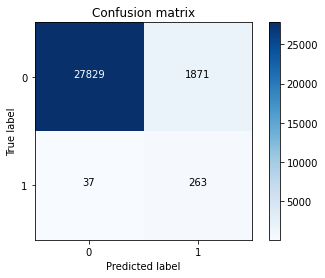

In [11]:
plot_confu(ground_truth, predict)

In [12]:
print_accuracy(ground_truth, confu)

True Acceptance Rate (TAR): 87.66666666666667%
True Rejection Rate (TRR): 93.70033670033669%
False Acceptance Rate (FAR): 6.299663299663299%
False Rejection Rate (FRR): 12.333333333333334%
Accuracy: 93.64%
Error Rate: 6.359999999999999%


### Threshold = 0.5

In [15]:
confu, predict, ground_truth = accuracy_score_iris(100, 100, 4, 0.5)

  0%|          | 0/30000 [00:00<?, ?it/s]

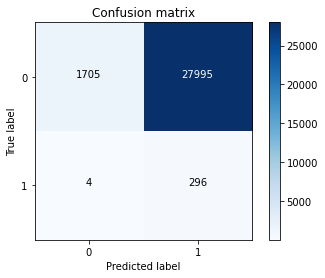

In [16]:
plot_confu(ground_truth, predict)

In [17]:
print_accuracy(ground_truth, confu)

True Acceptance Rate (TAR): 98.66666666666667%
True Rejection Rate (TRR): 5.7407407407407405%
False Acceptance Rate (FAR): 94.25925925925925%
False Rejection Rate (FRR): 1.3333333333333335%
Accuracy: 6.67%
Error Rate: 93.33%


## Accuracy Evalutaion Code Fusion

In [14]:
confu, predict, ground_truth = accuracy_score_multi_thread(200, 200, 4)

  0%|          | 0/120000 [00:00<?, ?it/s]

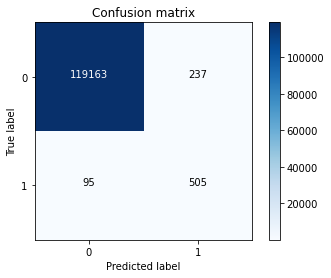

In [15]:
plot_confu(ground_truth, predict)

In [16]:
print_accuracy(ground_truth, confu)

True Acceptance Rate (TAR): 84.16666666666667%
True Rejection Rate (TRR): 99.80150753768844%
False Acceptance Rate (FAR): 0.19849246231155776%
False Rejection Rate (FRR): 15.833333333333332%
Accuracy: 99.72333333333333%
Error Rate: 0.2766666666666695%


## Testing Code

In [3]:
img_1_fol = 526
img_1_item = 2
img_2_fol = 526
img_2_item = 1

In [11]:
img_1_L = read_image(
    f'Iris-Dataset/CASIA-Iris-Thousand/{str(img_1_fol).zfill(3)}/L/S5{str(img_1_fol).zfill(3)}L{str((img_1_item + 1)*2).zfill(2)}.jpg')

img_1_R = read_image(
    f'Iris-Dataset/CASIA-Iris-Thousand/{str(img_1_fol).zfill(3)}/R/S5{str(img_1_fol).zfill(3)}R{str((img_1_item + 1)*2).zfill(2)}.jpg')

img_2_L = read_image(
    f'Iris-Dataset/CASIA-Iris-Thousand/{str(img_2_fol).zfill(3)}/L/S5{str(img_2_fol).zfill(3)}L{str((img_2_item + 1)*2).zfill(2)}.jpg')

img_2_R = read_image(
    f'Iris-Dataset/CASIA-Iris-Thousand/{str(img_2_fol).zfill(3)}/R/S5{str(img_2_fol).zfill(3)}R{str((img_2_item + 1)*2).zfill(2)}.jpg')

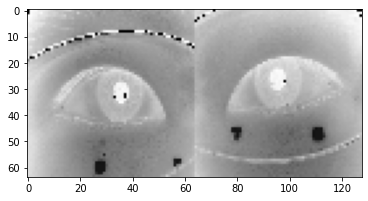

In [73]:
plt.imshow((Fusion_X[img_1_item + 4 * img_1_fol]*255).astype(np.uint8))

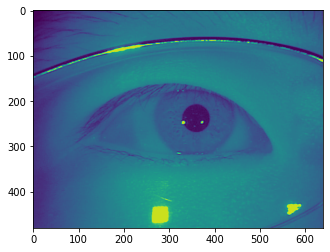

In [74]:
plt.imshow(img_1_L)

In [75]:
iris_score = iris_match(img_1_L, img_1_R, img_2_L, img_2_R)
peri_score = predict_image(features_test, str(img_1_fol).zfill(3), img_2_item + 4 * img_2_fol)
if iris_score == 'Match':
    print('Match')
elif iris_score == 'Not Sure' or iris_score == 'No Iris':
    print(peri_score)
else:
    print('Not Match')

Match
